# ANFIS classifier
***
A three label classifier for market behavior prediction based on Jang's original ANFIS architecture

## LUISS 'Guido Carli' - A.Y. 2023-24  
Machine Learning Project Submission

Marchioni Gian Lorenzo - Paquette David - Tomasella Elena
***

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import utilities
# utilities.py file contains functions for calculations and plots

import sys
sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis_gian')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nolds

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
msft = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Microsoft_weekly_ok.csv', 
                   index_col=False, 
                   parse_dates=['Date'])
amzn = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', 
                   index_col=False, 
                   parse_dates=['Date'])
ibm = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\IBM_weekly_ok.csv', 
                  index_col=False, 
                  parse_dates=['Date'])
cac = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Cac_weekly_ok.csv', 
                  index_col=False, 
                  parse_dates=['Date'])
sp500 = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Sp500_weekly_ok.csv', 
                    index_col=False, 
                    parse_dates=['Date'])
nasdaq = pd.read_csv(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Nasdaq_weekly_ok.csv', 
                     index_col=False, 
                     parse_dates=['Date'])

In [3]:
dfs = [amzn, cac, ibm, msft, nasdaq, sp500]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)

    df_name =[x for x in globals() if globals()[x] is df][0]
    print(f'Indicator parameters for {df_name}:')

    # Perform Grid Search to look for indicator parameters that maximize Hurst Exponent
    hurst_results_df=utilities.grid_search_hurst(df)
    print(hurst_results_df)
    print('─' * 77)
    
    # Access parameters for the indicators from the hurst_results_df
    rsi_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'RSI', 'Best Period'].values[0]
    cci_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CCI', 'Best Period'].values[0]
    ema_short_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Short Period'].values[0]
    ema_long_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Long Period'].values[0]
    cpc_window = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CPC', 'Best Period'].values[0]
        
    # Now use these values to calculate the indicators
    # Note that 'Best Short Period'  and  'Best Long Period' only applies for EMADN,
    # as it is the difference between two EMAs. 
    # The other indicators just have one parameter.
    df=utilities.calculate_indicators(df, 
                         rsi_period=rsi_period,
                         cci_period=cci_period, 
                         ema_short_period=ema_short_period, 
                         ema_long_period=ema_long_period, 
                         cpc_window=cpc_window)

    # Compute the weekly returns
    # Assign to each week the next one's return and convert it into the target variable (+1, 0, -1)
    # Target will be the categorical 'Next_week_market_behavior'
    df=utilities.preprocess_market_behavior(df)    

Indicator parameters for amzn:
  Indicator  Best Period  Hurst Exponent  Best Short Period  Best Long Period
0       CCI           36            0.90               <NA>              <NA>
1     EMADN         <NA>            0.92                 24                52
2       CPC           39            0.99               <NA>              <NA>
3       RSI           38            0.96               <NA>              <NA>
─────────────────────────────────────────────────────────────────────────────
Indicator parameters for cac:
  Indicator  Best Period  Hurst Exponent  Best Short Period  Best Long Period
0       CCI           38            0.91               <NA>              <NA>
1     EMADN         <NA>            0.94                 24                58
2       CPC           37            1.01               <NA>              <NA>
3       RSI           37            0.97               <NA>              <NA>
─────────────────────────────────────────────────────────────────────────────
Ind

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [4]:
amzn.head(5)

Date      Open      High       Low     Close        RSI        CCI  \
0 1998-09-27  0.633333  0.973958  0.633333  0.910420  63.689204  73.116444   
1 1998-10-04  0.969792  1.000000  0.833333  0.918750  64.744361  86.670801   
2 1998-10-11  0.907292  0.935417  0.666667  0.759895  60.301088  48.334561   
3 1998-10-18  0.809375  0.849479  0.747917  0.828645  61.244236  49.218548   
4 1998-10-25  0.825000  0.985938  0.825000  0.967710  63.245437  72.667787   

      EMADN  CPC  Current_week_pct_change  Next_week_pct_change  \
0  0.338982  1.0                37.098025              0.914962   
1  0.333435  1.0                 0.914962            -17.290340   
2  0.318557  1.0               -17.290340              9.047303   
3  0.308201  1.0                 9.047303             16.782217   
4  0.305449  1.0                16.782217              8.880243   

   Next_week_market_behavior  
0                          1  
1                         -1  
2                          1  
3                          1  
4                          1

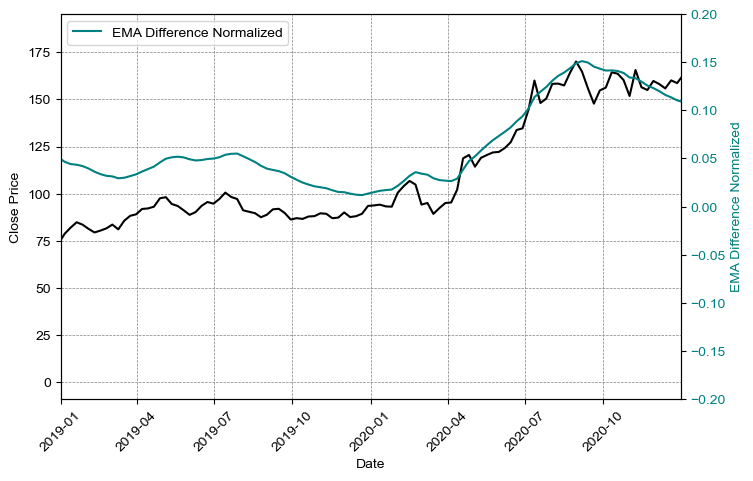

In [5]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMADN'], color='#008080', label='EMA Difference Normalized')
ax2.set_ylabel('EMA Difference Normalized', color='#008080')
ax2.tick_params(axis='y', labelcolor='#008080')
ax2.set_ylim([-0.2, 0.2])
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMADN.png', transparent=True)
plt.show()

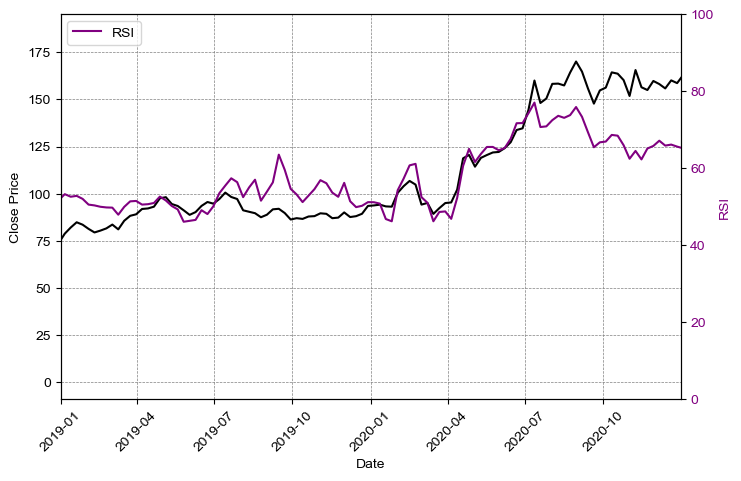

In [6]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='#800080', label='RSI')
ax2.set_ylabel('RSI', color='#800080')
ax2.set_ylim([0, 100])
ax2.tick_params(axis='y', labelcolor='#800080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('RSI.png', transparent=True)
plt.show()

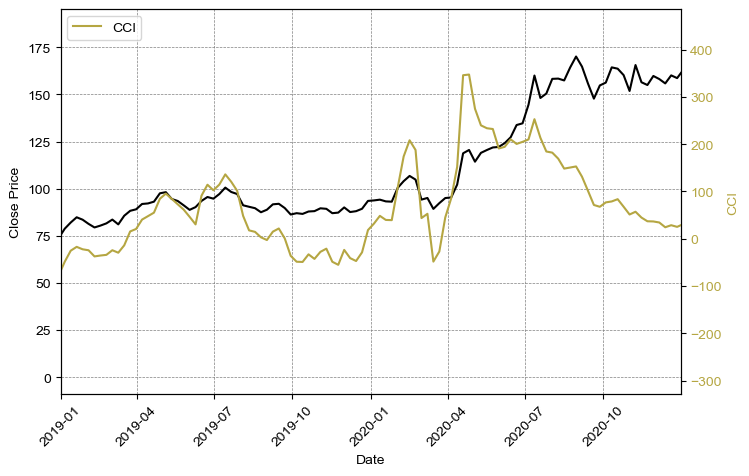

In [7]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='#B5A642', label='CCI')
ax2.set_ylabel('CCI', color='#B5A642')
ax2.tick_params(axis='y', labelcolor='#B5A642')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CCI.png', transparent=True)

plt.show()

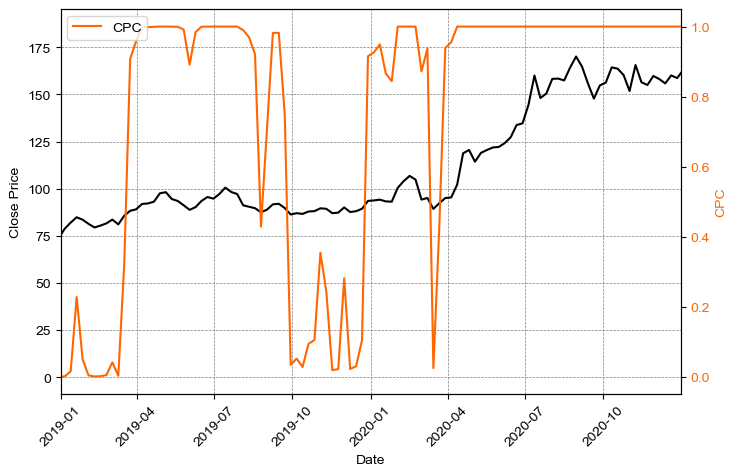

In [8]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='#FF6600', label='CPC')
ax2.set_ylabel('CPC', color='#FF6600')
ax2.tick_params(axis='y', labelcolor='#FF6600')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CPC.png', transparent=True)

plt.show()

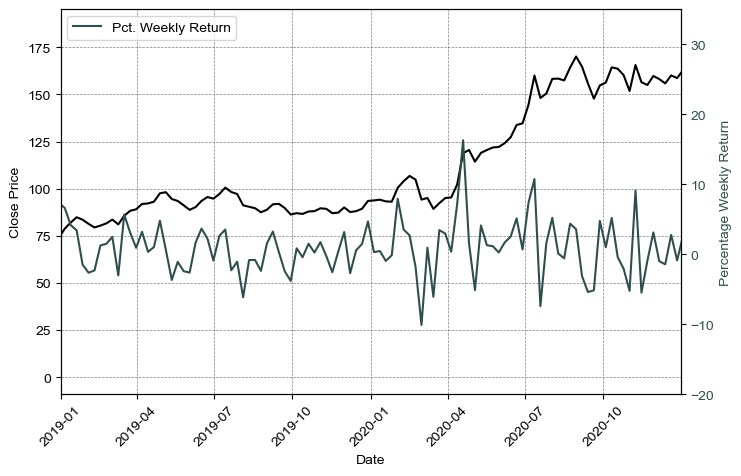

In [9]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['Current_week_pct_change'], color='#2F4F4F', label='Pct. Weekly Return')
ax2.set_ylabel('Percentage Weekly Return', color='#2F4F4F')
ax2.set_ylim([-20, 35])
ax2.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('PercentageReturn.png', transparent=True)

plt.show()

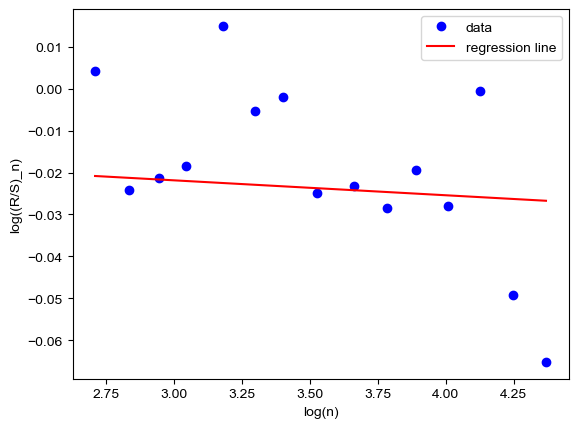

Hurst exponent (R/S estimate) for Weekly Return series: 0.5


In [10]:
H_rs=nolds.hurst_rs(data=amzn['Current_week_pct_change'], debug_plot=True)
print("Hurst exponent (R/S estimate) for Weekly Return series:", round(H_rs,2))

***
# Training and Validation
The model is trained on each dataset uning a 90-10 split. After each training, it will be cross-tested using the other test sets.

In [11]:
# Define your feature columns
feature_columns = ['RSI', 'CCI', 'CPC', 'EMADN', 'Current_week_pct_change']

# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('EMADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

# Instance the anfis classifier model, specifying the number of output classes
model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

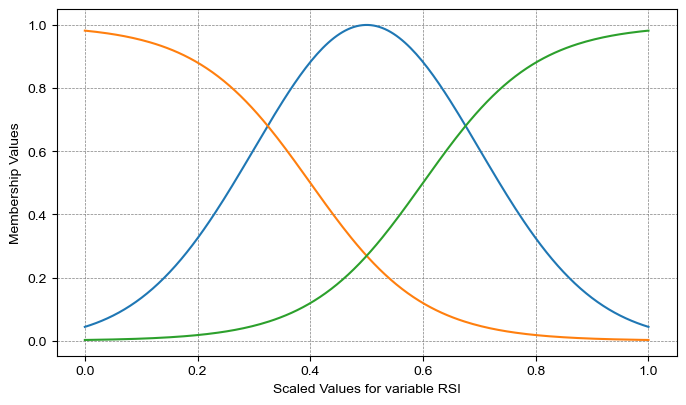

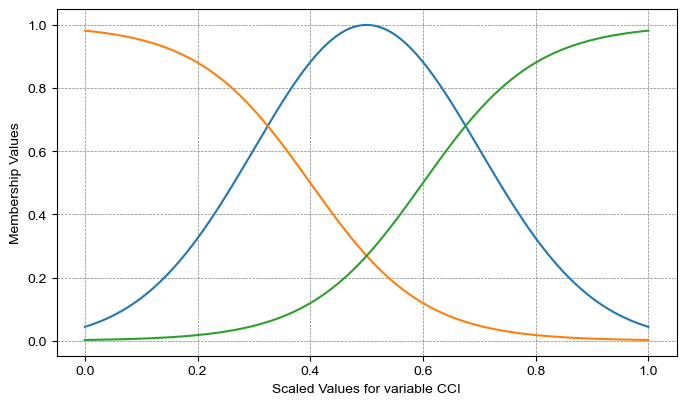

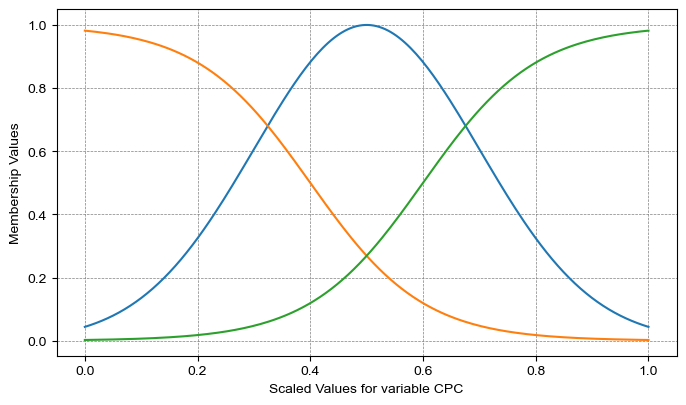

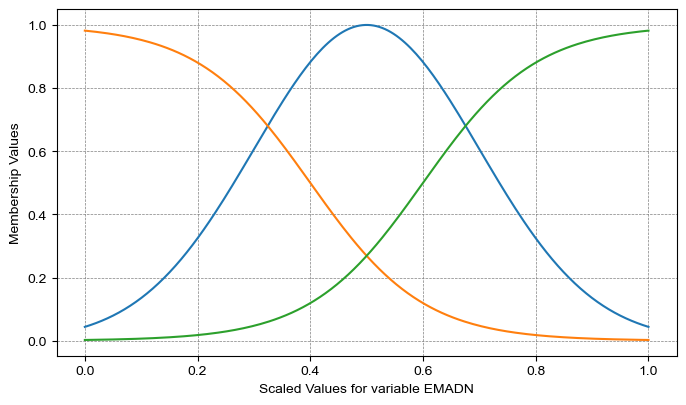

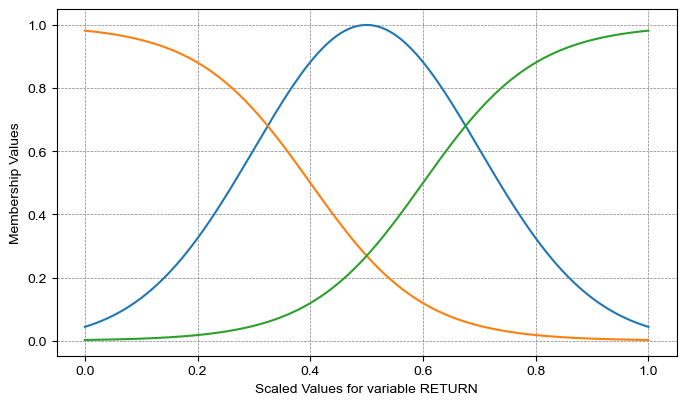

Initial Membership Functions:


In [12]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)
experimental.plot_all_mfs(model, x)
print('Initial Membership Functions:')

***
## AMZN dataset

In [13]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Initialize and apply the MinMaxScaler
    scaler = MinMaxScaler()
    features = test_df[feature_columns]
    scaled_features = scaler.fit_transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    amzn_name: amzn_test_df,
    ibm_name: ibm_test_df,
    msft_name: msft_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}

### Training for 500 epochs, training size = 1194 cases
epoch    0: Loss=1.08021
epoch   10: Loss=0.95479
epoch   20: Loss=0.92861
epoch   30: Loss=0.92377
epoch   40: Loss=0.92126
epoch   50: Loss=0.91972
epoch   60: Loss=0.91785
epoch   70: Loss=0.91422
epoch   80: Loss=0.91191
epoch   90: Loss=0.91014
epoch  100: Loss=0.90908
epoch  110: Loss=0.90779
epoch  120: Loss=0.90775
epoch  130: Loss=0.90700
epoch  140: Loss=0.90628
epoch  150: Loss=0.90586
epoch  160: Loss=0.90536
epoch  170: Loss=0.90448
epoch  180: Loss=0.90361
epoch  190: Loss=0.90278
epoch  200: Loss=0.90200
epoch  210: Loss=0.90129
epoch  220: Loss=0.90063
epoch  230: Loss=0.90002
epoch  240: Loss=0.89948
epoch  250: Loss=0.89898
epoch  260: Loss=0.89852
epoch  270: Loss=0.89815
epoch  280: Loss=0.89781
epoch  290: Loss=0.89750
epoch  300: Loss=0.89722
epoch  310: Loss=0.89696
epoch  320: Loss=0.89674
epoch  330: Loss=0.89655
epoch  340: Loss=0.89635
epoch  350: Loss=0.89628
epoch  360: Loss=0.89594
epoch  370: Loss=0.

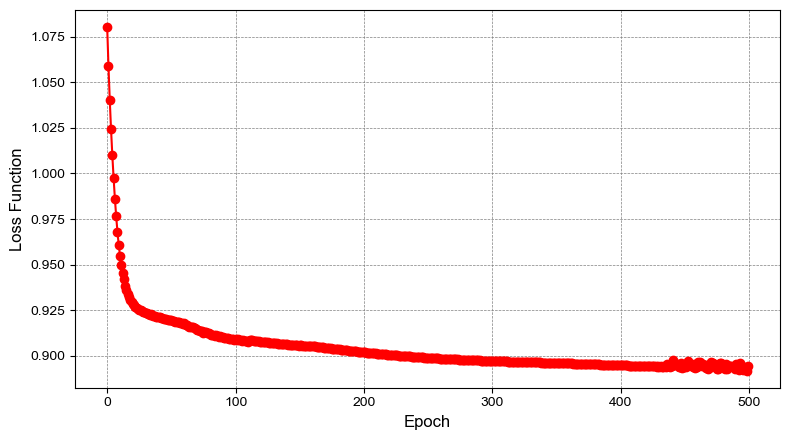

In [14]:
df=amzn
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 52.0 %
────────────────────────────────────────


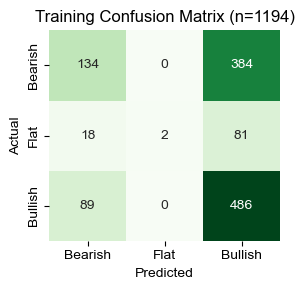

In [15]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 50.0 %
────────────────────────────────────────


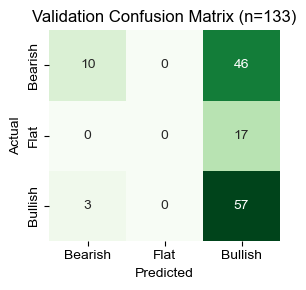

In [16]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

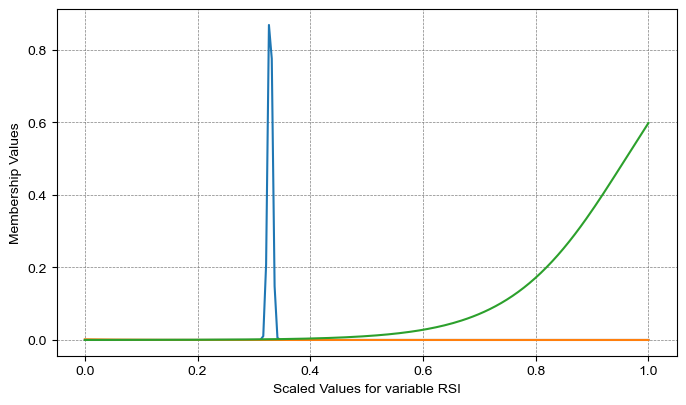

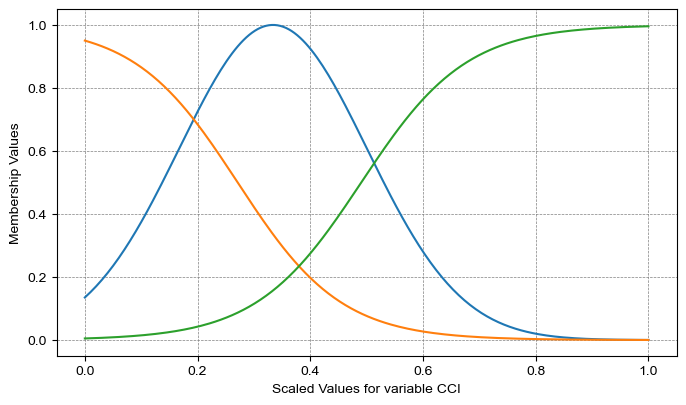

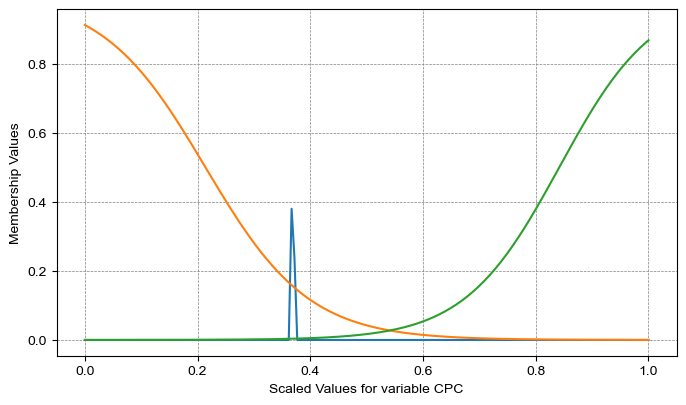

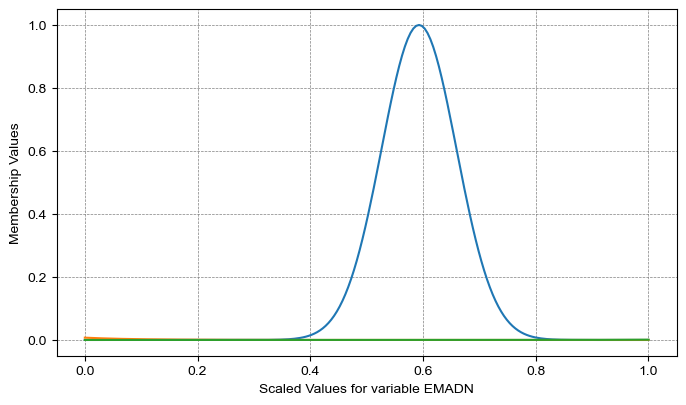

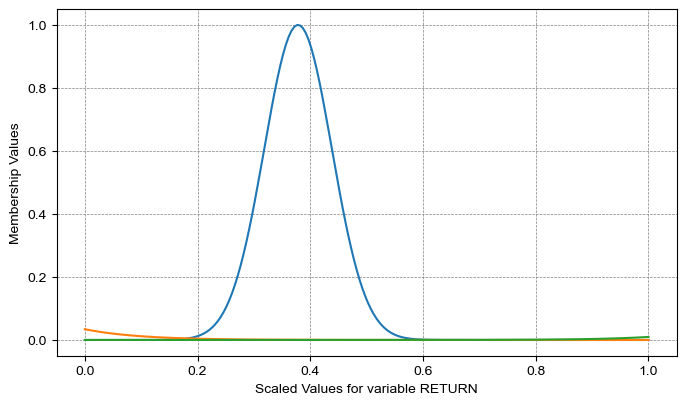

Membership Functions after training:


In [17]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)
experimental.plot_all_mfs(model, x)
print('Membership Functions after training:')

Cumulative return over the period: 4789848.4 %
Baseline Return (Buy and Hold over the period): 19120.8 %
Maximum Drawdown Duration 130 weeks


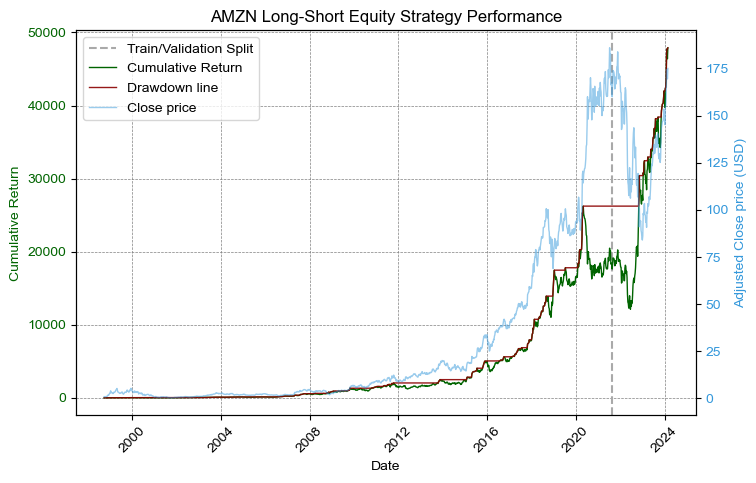

In [18]:
# Combine predictions into a single column
amzn['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

amzn=utilities.calculate_returns(amzn, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(amzn, 'AMZN', train_test_split=0.9, save_figure=False)

Cumulative return over the period: 76.3 %
Baseline Return (Buy and Hold over the period): 6.2 %
Validation Set Maximum Drawdown: 6 weeks


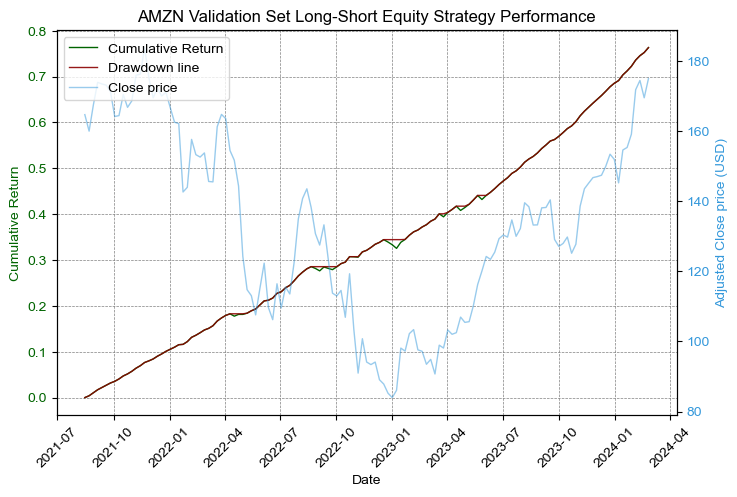

In [19]:
amzn_test_df['Prediction']=predicted_labels_test
amzn_test_df = utilities.calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(amzn_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(amzn_test_df, 'AMZN Validation Set')

In [20]:
utilities.calculate_yearly_returns(amzn_test_df)

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 27.4 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 3 weeks
────────────────────────────────────────
Cumulative return over the period: 18.1 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────


Cross-testing on IBM Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 4.8 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 112 weeks
────────────────────────────────────────


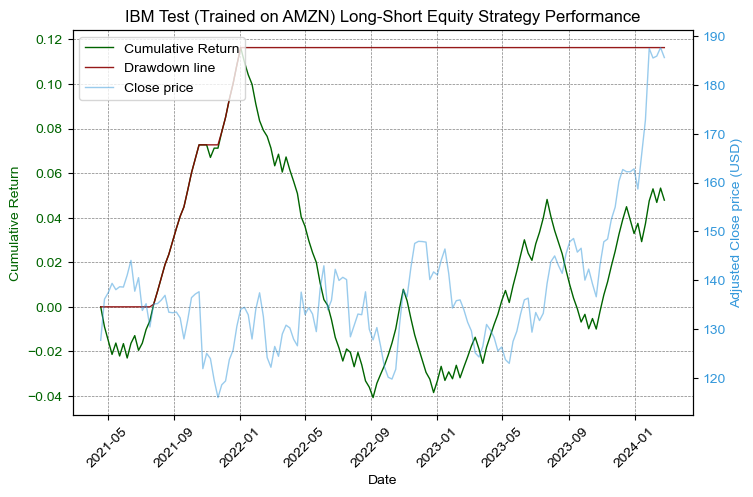

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 5.6 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 14 weeks
────────────────────────────────────────
Cumulative return over the period: -6.1 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 3.1 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 83 weeks
────────────────────────────────────────


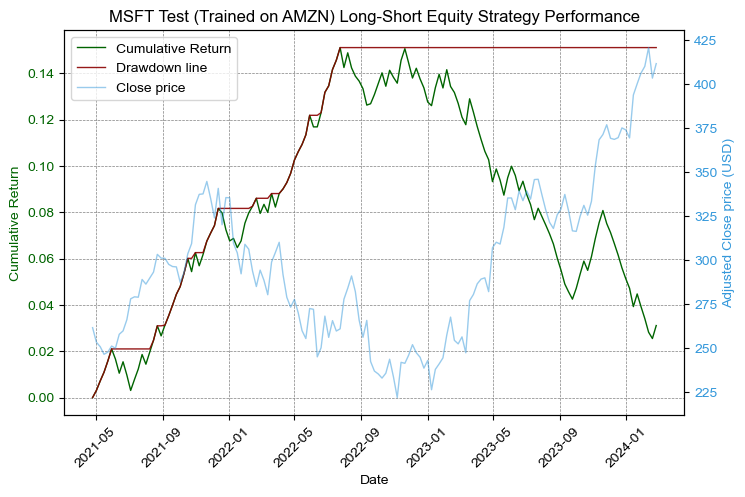

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 9.3 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 10 weeks
────────────────────────────────────────
Cumulative return over the period: 0.9 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 38 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 35.0 %
────────────────────────────────────────
Cumulative return over the period: -4.9 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 81 weeks
────────────────────────────────────────


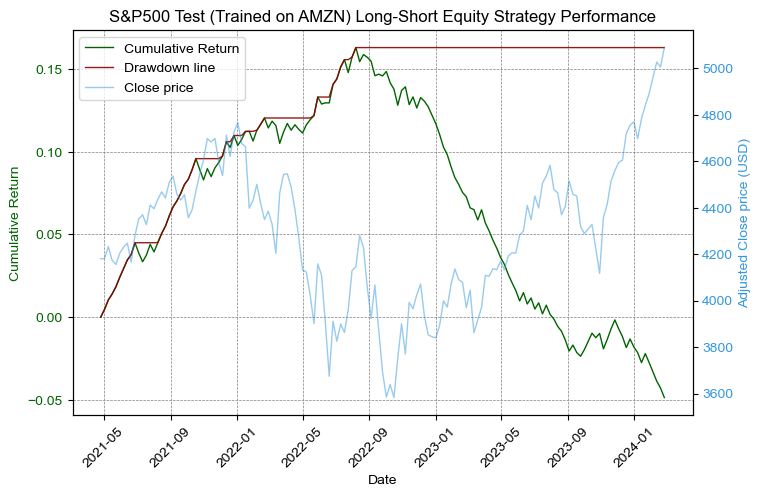

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 11.6 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: -6.0 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 37.0 %
────────────────────────────────────────
Cumulative return over the period: -3.1 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 81 weeks
────────────────────────────────────────


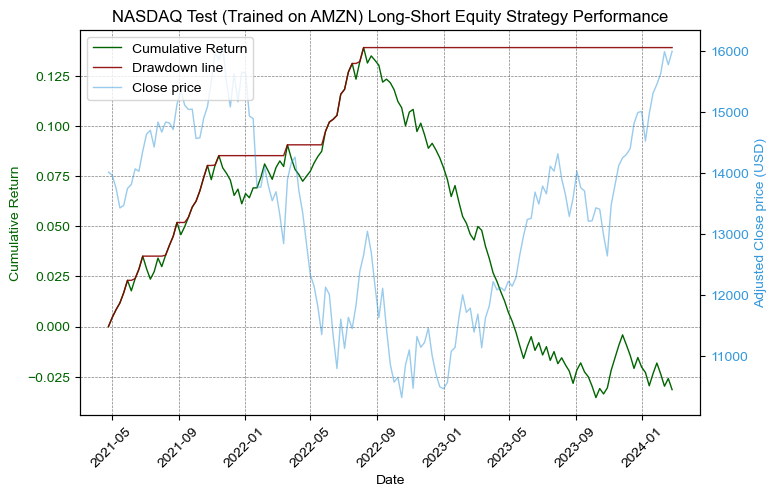

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 7.2 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 17 weeks
────────────────────────────────────────
Cumulative return over the period: -5.4 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 17.0 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 61 weeks
────────────────────────────────────────


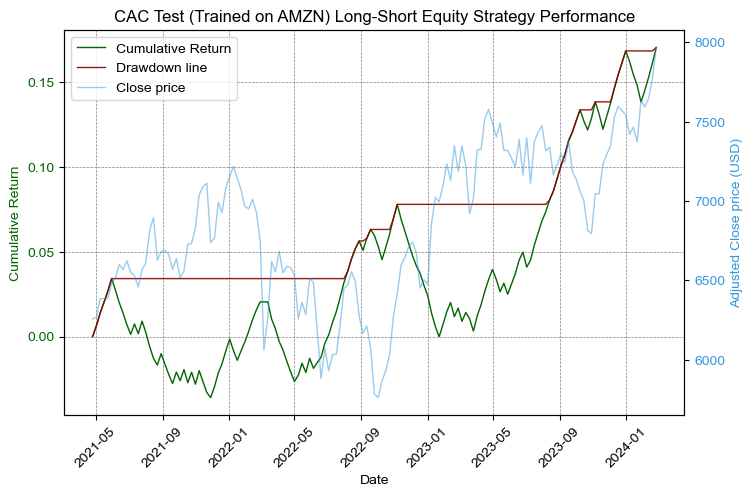

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -1.5 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 46 weeks
────────────────────────────────────────
Cumulative return over the period: 4.9 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 23 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [21]:
for df_name, df in test_dfs.items():
    if df_name != 'AMZN Test':  # Skip the current test dataset for cross-testing

        actual_labels_test = df['Next_week_market_behavior']
        
        X_test = df[feature_columns].values
        
        X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
        X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

        predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

        print(f'Cross-testing on {df_name}')
        # Accuracy
        accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
        print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
        print('─' * 40)

        # Returns
        df['Prediction'] = predicted_labels_test

        df=utilities.calculate_returns(df, 'Prediction')
        
        max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
        
        print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
        print('─' * 40) 

        utilities.plot_return(df, df_name+' (Trained on AMZN)', save_figure=True)

        utilities.calculate_yearly_returns(df)

        print('─' * 100)

***
## MSFT dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.19503
epoch   10: Loss=1.02223
epoch   20: Loss=1.01216
epoch   30: Loss=1.00995
epoch   40: Loss=1.01300
epoch   50: Loss=1.00506
epoch   60: Loss=0.99561
epoch   70: Loss=0.99259
epoch   80: Loss=0.98530
epoch   90: Loss=0.98507
epoch  100: Loss=0.98176
epoch  110: Loss=0.98221
epoch  120: Loss=0.97884
epoch  130: Loss=0.98160
epoch  140: Loss=0.97685
epoch  150: Loss=0.97700
epoch  160: Loss=0.97702
epoch  170: Loss=0.98208
epoch  180: Loss=0.97466
epoch  190: Loss=0.97251
epoch  200: Loss=0.97380
epoch  210: Loss=0.96997
epoch  220: Loss=0.97818
epoch  230: Loss=0.96866
epoch  240: Loss=0.97947
epoch  250: Loss=0.97242
epoch  260: Loss=0.96923
epoch  270: Loss=0.96769
epoch  280: Loss=0.96654
epoch  290: Loss=0.96607
epoch  300: Loss=0.96533
epoch  310: Loss=0.96459
epoch  320: Loss=0.96381
epoch  330: Loss=0.96296
epoch  340: Loss=0.96212
epoch  350: Loss=0.96146
epoch  360: Loss=0.96082
epoch  370: Loss=0.

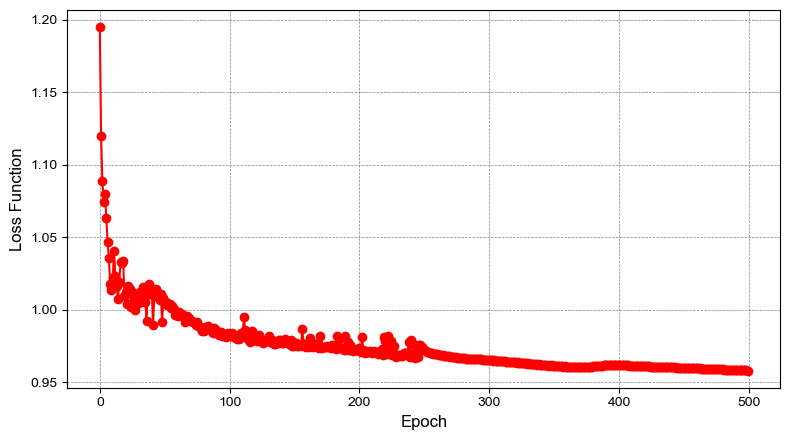

In [22]:
df=msft
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 52.0 %
────────────────────────────────────────


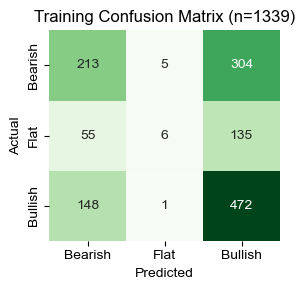

In [23]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 45.0 %
────────────────────────────────────────


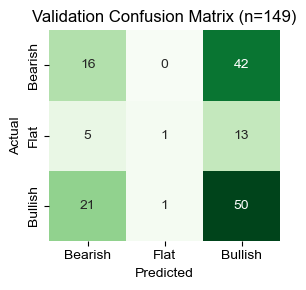

In [24]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 113739.3 %
Baseline Return (Buy and Hold over the period): 6875.7 %
Maximum Drawdown Duration 130 weeks


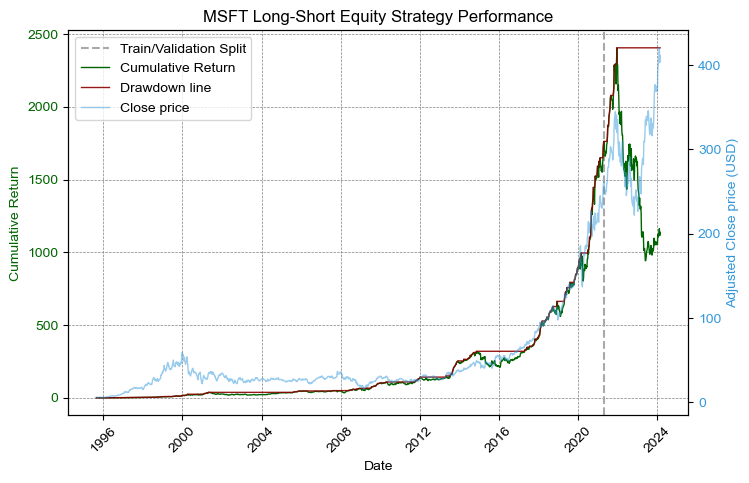

In [25]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'MSFT', train_test_split=0.9, save_figure=True)

In [26]:
msft_test_df

Date    Close       RSI       CCI     EMADN       CPC  \
1339 2021-04-25  261.660  0.569554  0.750460  0.865853  1.000000   
1340 2021-05-02  253.400  0.518716  0.697427  0.866260  0.999998   
1341 2021-05-09  250.870  0.516017  0.643148  0.861803  0.999989   
1342 2021-05-16  246.550  0.468780  0.593822  0.851087  0.999875   
1343 2021-05-23  247.785  0.418266  0.584272  0.841257  0.999892   
...         ...      ...       ...       ...       ...       ...   
1483 2024-01-28  406.060  0.756748  0.692336  0.802389  1.000000   
1484 2024-02-04  409.900  0.774655  0.704201  0.819677  1.000000   
1485 2024-02-11  420.555  0.777983  0.724240  0.840793  1.000000   
1486 2024-02-18  403.240  0.620921  0.685432  0.844707  1.000000   
1487 2024-02-25  411.455  0.648486  0.672793  0.852222  1.000000   

      Current_week_pct_change  Next_week_pct_change  \
1339                 0.478948             -3.156768   
1340                 0.308712             -0.998421   
1341                 0.407437             -1.722007   
1342                 0.374339              0.500913   
1343                 0.476018              1.390318   
...                       ...                   ...   
1483                 0.522171              0.945673   
1484                 0.496361              2.599414   
1485                 0.572005             -4.117178   
1486                 0.264782              2.037248   
1487                 0.546291             -0.951501   

      Next_week_market_behavior  Prediction  Portfolio_Return  \
1339                         -1           1          0.000000   
1340                         -1           1          0.003087   
1341                         -1           1          0.004074   
1342                          1           1          0.003743   
1343                          1           1          0.004760   
...                         ...         ...               ...   
1483                          1          -1         -0.005222   
1484                          1          -1         -0.004964   
1485                         -1          -1         -0.005720   
1486                          1           1         -0.002648   
1487                         -1           1          0.005463   

      Cumulative_Return  High_Water_Mark  
1339           0.000000         0.000000  
1340           0.003087         0.003087  
1341           0.007174         0.007174  
1342           0.010944         0.010944  
1343           0.015757         0.015757  
...                 ...              ...  
1483           0.039292         0.151094  
1484           0.034133         0.151094  
1485           0.028218         0.151094  
1486           0.025495         0.151094  
1487           0.031097         0.151094  

[149 rows x 13 columns]

Cumulative return over the period: 30.1 %
Baseline Return (Buy and Hold over the period): 57.2 %
Validation Set Maximum Drawdown: 42 weeks


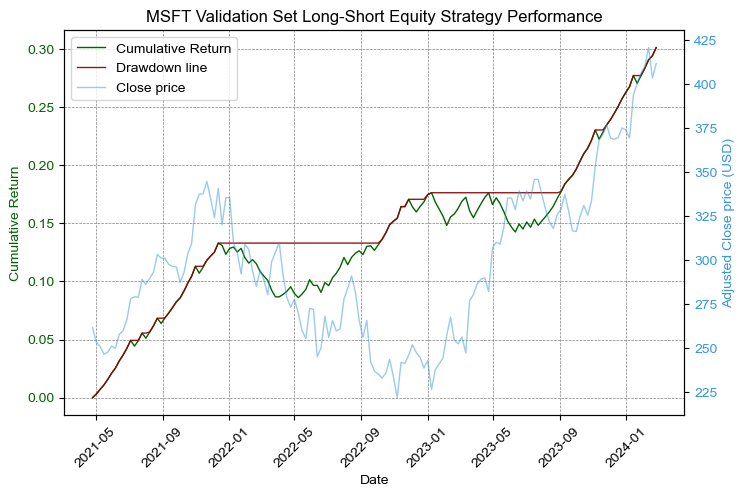

In [27]:
msft_test_df['Prediction']=predicted_labels_test
msft_test_df = utilities.calculate_returns(msft_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(msft_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(msft_test_df, 'MSFT Validation Set', save_figure=True)

In [28]:
utilities.calculate_yearly_returns(msft_test_df)

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 9.1 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 18 weeks
────────────────────────────────────────
Cumulative return over the period: 7.0 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 14 weeks
────────────────────────────────────────


Cross-testing on AMZN Test
Cross-Test Accuracy: 35.0 %
────────────────────────────────────────
Cumulative return over the period: -18.1 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 81 weeks
────────────────────────────────────────


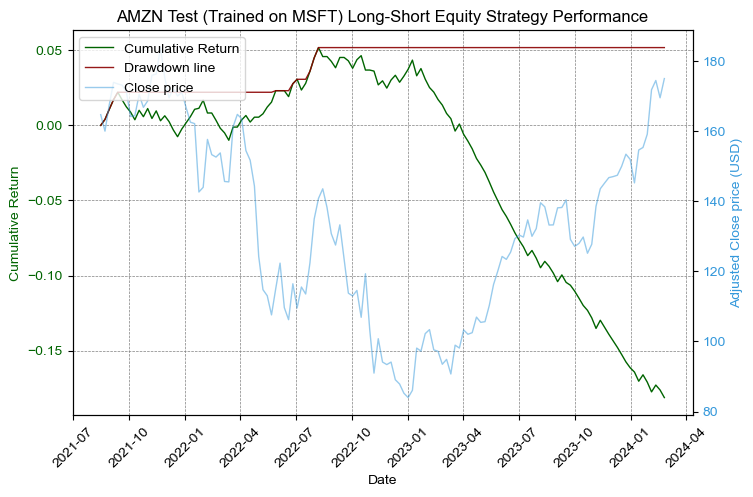

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 5.2 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
Cumulative return over the period: -13.4 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 42 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: -10.1 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 99 weeks
────────────────────────────────────────


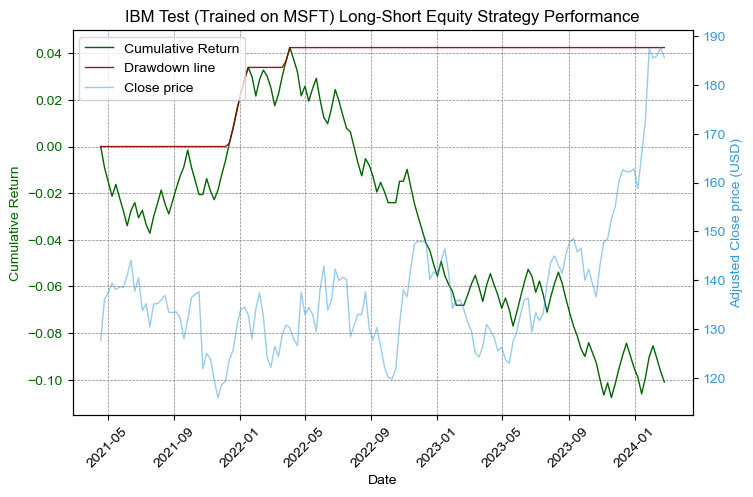

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 3.7 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 33 weeks
────────────────────────────────────────
Cumulative return over the period: -8.4 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 32.0 %
────────────────────────────────────────
Cumulative return over the period: -23.9 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 148 weeks
────────────────────────────────────────


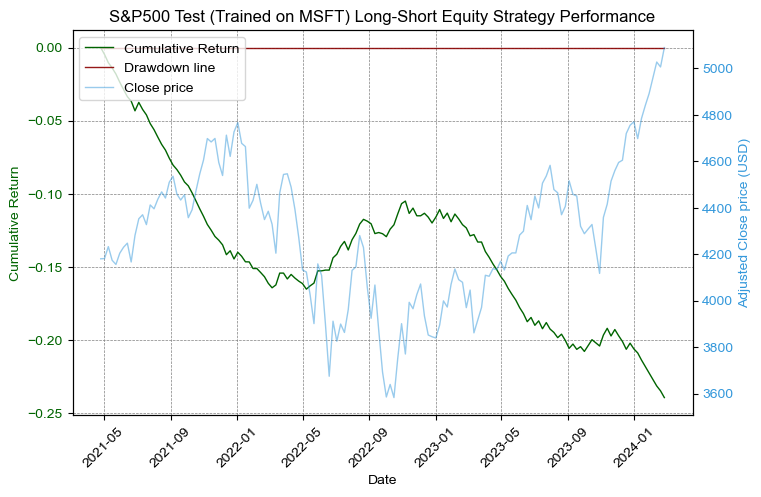

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -15.8 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
Cumulative return over the period: 1.4 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 23 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 40.0 %
────────────────────────────────────────
Cumulative return over the period: -24.7 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 148 weeks
────────────────────────────────────────


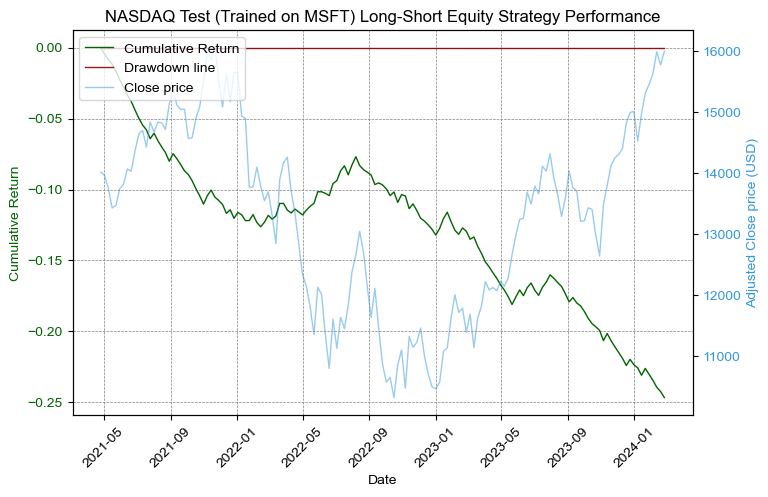

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -11.4 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
Cumulative return over the period: -4.8 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 39.0 %
────────────────────────────────────────
Cumulative return over the period: 9.9 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 28 weeks
────────────────────────────────────────


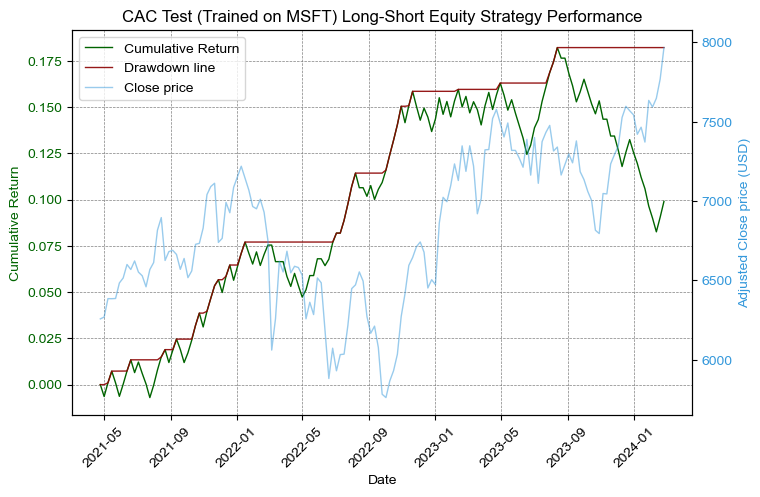

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 6.0 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 13 weeks
────────────────────────────────────────
Cumulative return over the period: 9.0 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [29]:
for df_name, df in test_dfs.items():
    if df_name != 'MSFT Test':  # Skip the current test dataset for cross-testing

        actual_labels_test = df['Next_week_market_behavior']
        
        X_test = df[feature_columns].values
        
        X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
        X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

        predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

        print(f'Cross-testing on {df_name}')
        # Accuracy
        accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
        print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
        print('─' * 40)

        # Returns
        df['Prediction'] = predicted_labels_test

        df=utilities.calculate_returns(df, 'Prediction')
        
        max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
        
        print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
        print('─' * 40) 

        utilities.plot_return(df, df_name+' (Trained on MSFT)', save_figure=True)

        utilities.calculate_yearly_returns(df)

        print('─' * 100)

***
## IBM dataset

### Training for 500 epochs, training size = 1342 cases
epoch    0: Loss=1.14361
epoch   10: Loss=1.02962
epoch   20: Loss=1.00774
epoch   30: Loss=1.02253
epoch   40: Loss=1.00089
epoch   50: Loss=0.99879
epoch   60: Loss=0.99365
epoch   70: Loss=0.99261
epoch   80: Loss=0.99097
epoch   90: Loss=0.98973
epoch  100: Loss=0.98795
epoch  110: Loss=0.98664
epoch  120: Loss=0.98541
epoch  130: Loss=0.98407
epoch  140: Loss=0.98278
epoch  150: Loss=0.98159
epoch  160: Loss=0.98048
epoch  170: Loss=0.97937
epoch  180: Loss=0.97810
epoch  190: Loss=0.97566
epoch  200: Loss=0.97420
epoch  210: Loss=0.97332
epoch  220: Loss=0.97264
epoch  230: Loss=0.97198
epoch  240: Loss=0.97111
epoch  250: Loss=0.96992
epoch  260: Loss=0.96853
epoch  270: Loss=0.96791
epoch  280: Loss=0.96660
epoch  290: Loss=0.96535
epoch  300: Loss=0.96455
epoch  310: Loss=0.96395
epoch  320: Loss=0.96347
epoch  330: Loss=0.96293
epoch  340: Loss=0.96240
epoch  350: Loss=0.96195
epoch  360: Loss=0.96149
epoch  370: Loss=0.

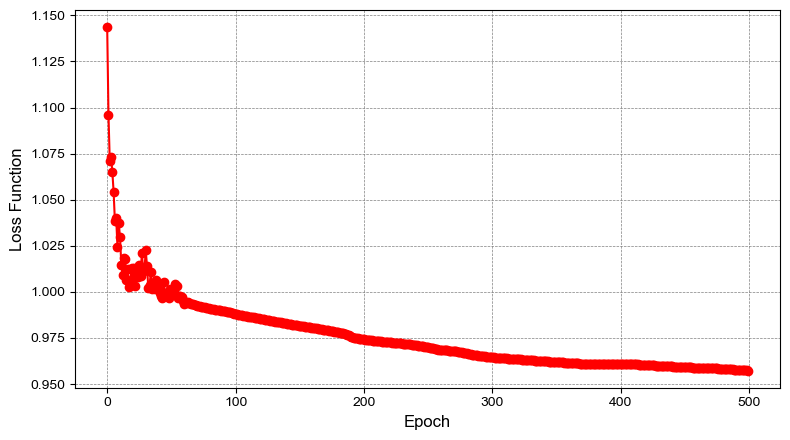

In [30]:
df=ibm
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 50.0 %
────────────────────────────────────────


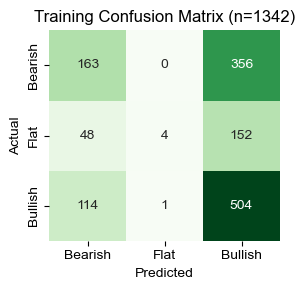

In [31]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 42.0 %
────────────────────────────────────────


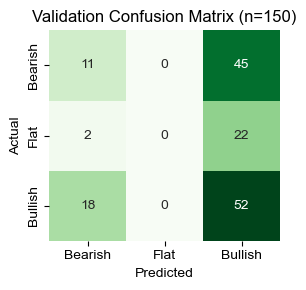

In [32]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 3556.8 %
Baseline Return (Buy and Hold over the period): 602.0 %
Maximum Drawdown Duration 130 weeks


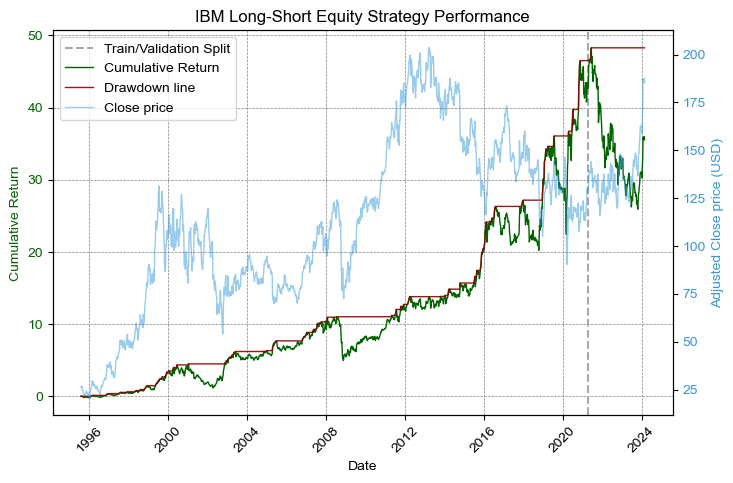

In [33]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'IBM', train_test_split=0.9, save_figure=True)

Cumulative return over the period: -18.1 %
Baseline Return (Buy and Hold over the period): 6.2 %
Validation Set Maximum Drawdown: 81 weeks


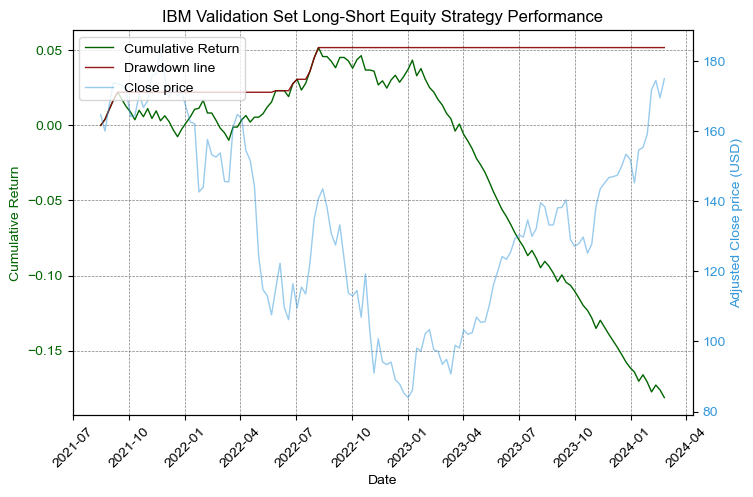

In [34]:
ibm_test_df['Prediction']=predicted_labels_test
ibm_test_df = utilities.calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(ibm_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(ibm_test_df, 'IBM Validation Set', save_figure=True)

In [35]:
utilities.calculate_yearly_returns(ibm_test_df)

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 5.2 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
Cumulative return over the period: -13.4 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 42 weeks
────────────────────────────────────────


Cross-testing on AMZN Test
Cross-Test Accuracy: 47.0 %
────────────────────────────────────────
Cumulative return over the period: 24.0 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 13 weeks
────────────────────────────────────────


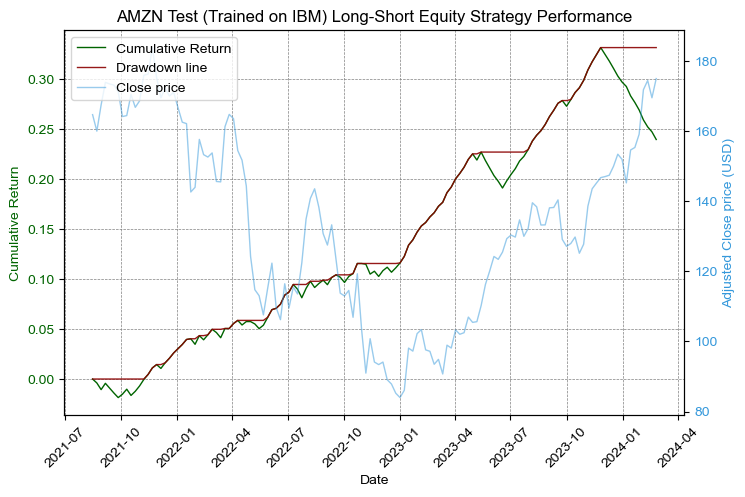

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 9.8 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 12 weeks
────────────────────────────────────────
Cumulative return over the period: 13.4 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 10 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 47.0 %
────────────────────────────────────────
Cumulative return over the period: 46.2 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 32 weeks
────────────────────────────────────────


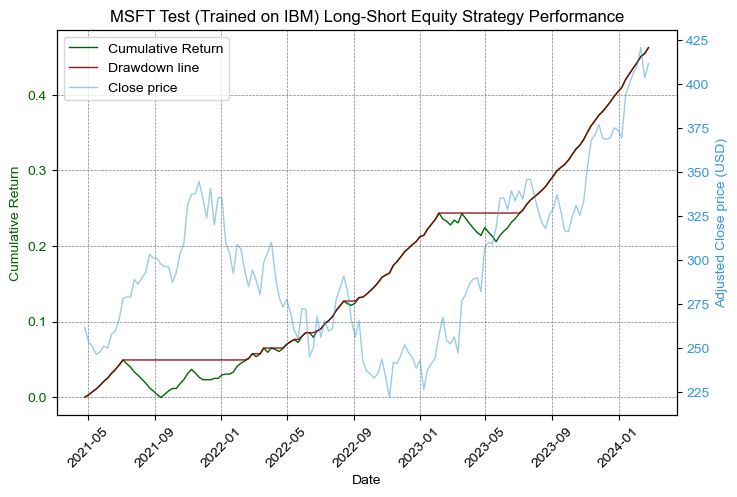

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 6.0 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 32 weeks
────────────────────────────────────────
Cumulative return over the period: 14.4 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 10 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 48.8 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 18 weeks
────────────────────────────────────────


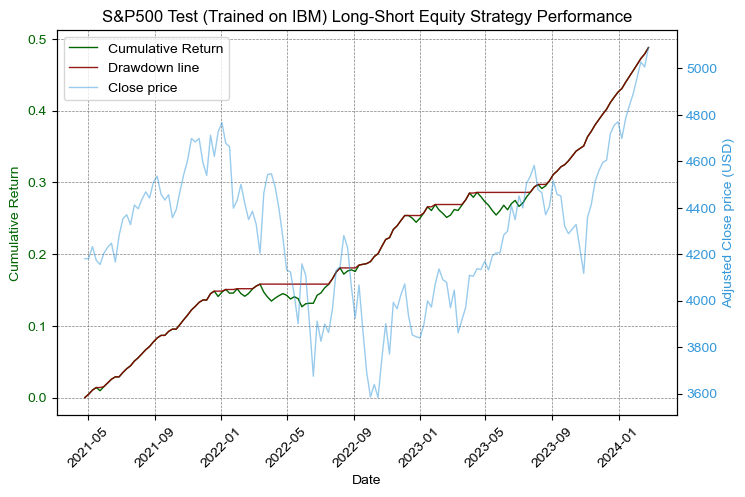

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.2 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 5 weeks
────────────────────────────────────────
Cumulative return over the period: 12.3 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 50.0 %
────────────────────────────────────────
Cumulative return over the period: 66.9 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 16 weeks
────────────────────────────────────────


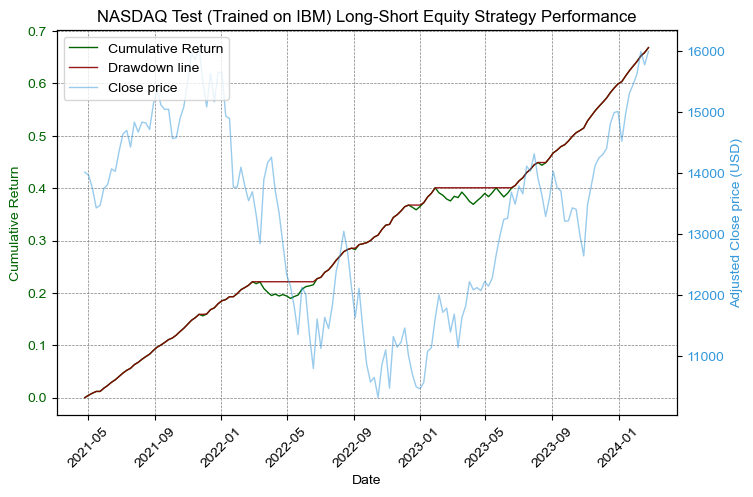

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 19.4 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────
Cumulative return over the period: 15.0 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 47.8 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 16 weeks
────────────────────────────────────────


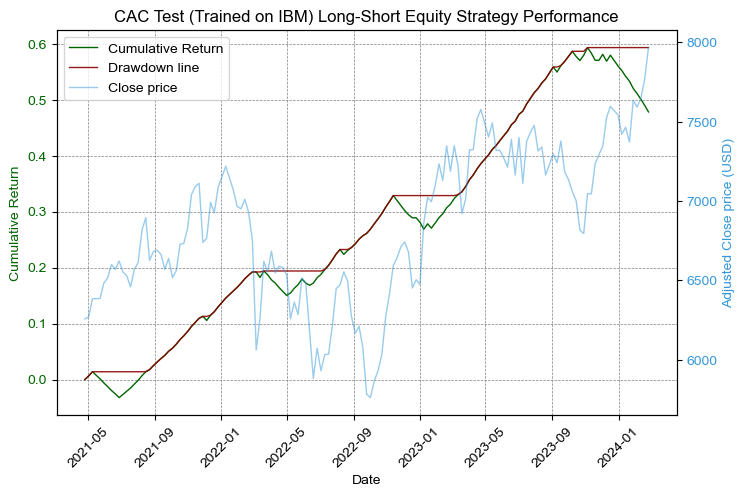

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.4 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 14 weeks
────────────────────────────────────────
Cumulative return over the period: 19.0 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 16 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [36]:
for df_name, df in test_dfs.items():
    if df_name != 'IBM Test':  # Skip the current test dataset for cross-testing

        actual_labels_test = df['Next_week_market_behavior']
        
        X_test = df[feature_columns].values
        
        X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
        X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

        predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

        print(f'Cross-testing on {df_name}')
        # Accuracy
        accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
        print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
        print('─' * 40)

        # Returns
        df['Prediction'] = predicted_labels_test

        df=utilities.calculate_returns(df, 'Prediction')
        
        max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
        
        print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
        print('─' * 40) 

        utilities.plot_return(df, df_name+' (Trained on IBM)', save_figure=True)

        utilities.calculate_yearly_returns(df)

        print('─' * 100)

***
## CAC dataset

### Training for 500 epochs, training size = 1341 cases
epoch    0: Loss=1.19115
epoch   10: Loss=1.02370
epoch   20: Loss=1.01025
epoch   30: Loss=1.00562
epoch   40: Loss=1.00337
epoch   50: Loss=1.00225
epoch   60: Loss=1.00017
epoch   70: Loss=0.99913
epoch   80: Loss=0.99895
epoch   90: Loss=0.99798
epoch  100: Loss=0.99599
epoch  110: Loss=0.99318
epoch  120: Loss=0.99218
epoch  130: Loss=0.99280
epoch  140: Loss=0.99394
epoch  150: Loss=0.99129
epoch  160: Loss=0.99151
epoch  170: Loss=0.98936
epoch  180: Loss=0.98865
epoch  190: Loss=0.98544
epoch  200: Loss=0.98622
epoch  210: Loss=0.98710
epoch  220: Loss=0.98590
epoch  230: Loss=0.98520
epoch  240: Loss=0.98452
epoch  250: Loss=0.98387
epoch  260: Loss=0.98326
epoch  270: Loss=0.98269
epoch  280: Loss=0.98207
epoch  290: Loss=0.98153
epoch  300: Loss=0.98102
epoch  310: Loss=0.98057
epoch  320: Loss=0.97999
epoch  330: Loss=0.97949
epoch  340: Loss=0.97894
epoch  350: Loss=0.97844
epoch  360: Loss=0.97794
epoch  370: Loss=0.

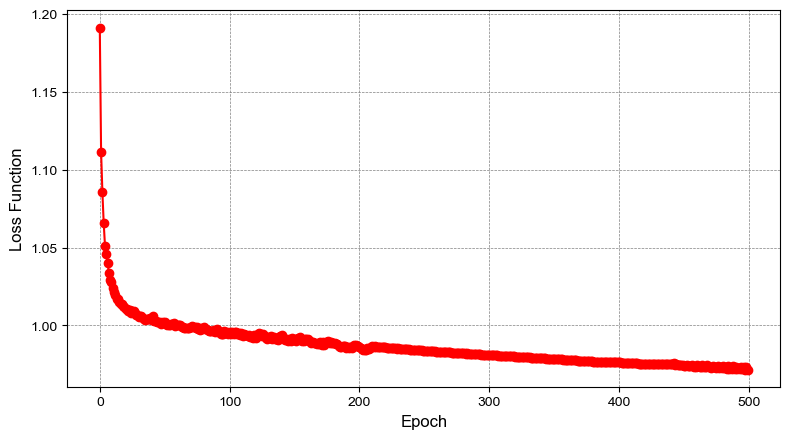

In [37]:
df=cac
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 49.0 %
────────────────────────────────────────


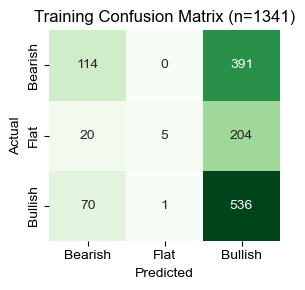

In [38]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 44.0 %
────────────────────────────────────────


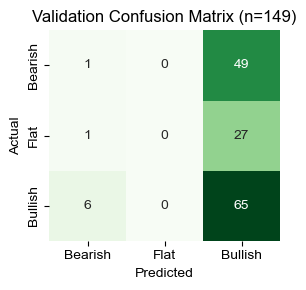

In [39]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 10952.6 %
Baseline Return (Buy and Hold over the period): 309.3 %
Maximum Drawdown Duration 130 weeks


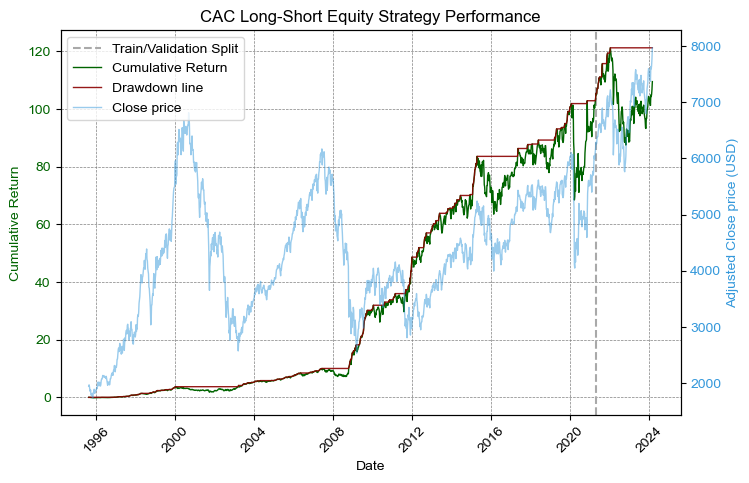

In [40]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'CAC', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 130.4 %
Baseline Return (Buy and Hold over the period): 27.3 %
Validation Set Maximum Drawdown: 7 weeks


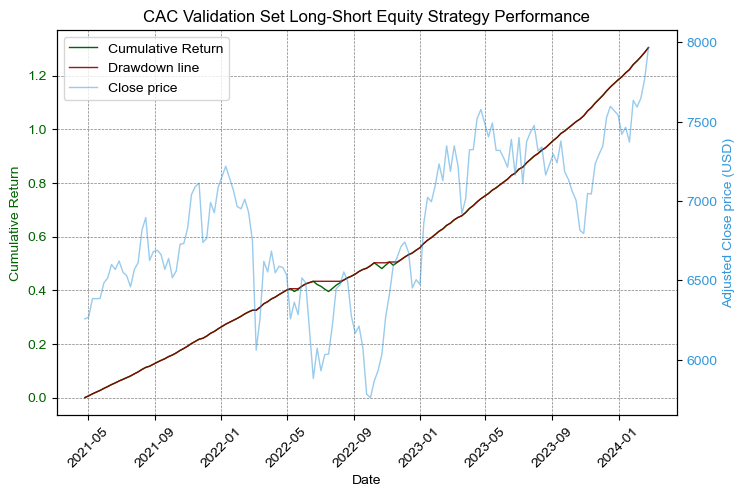

In [41]:
cac_test_df['Prediction']=predicted_labels_test
cac_test_df = utilities.calculate_returns(cac_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(cac_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(cac_test_df, 'CAC Validation Set', save_figure=True)

In [42]:
utilities.calculate_yearly_returns(cac_test_df)

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 38.4 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 0 weeks
────────────────────────────────────────
Cumulative return over the period: 24.2 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────


Cross-testing on AMZN Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 43.7 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 15 weeks
────────────────────────────────────────


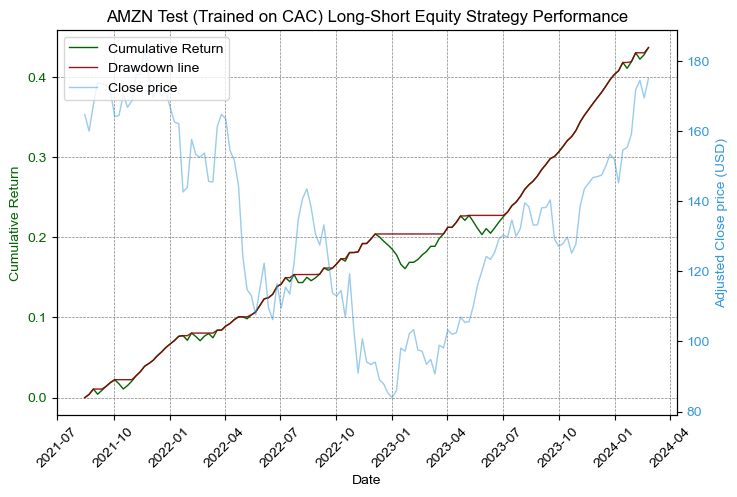

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.4 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 5 weeks
────────────────────────────────────────
Cumulative return over the period: 9.5 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 15 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 39.0 %
────────────────────────────────────────
Cumulative return over the period: 0.4 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 117 weeks
────────────────────────────────────────


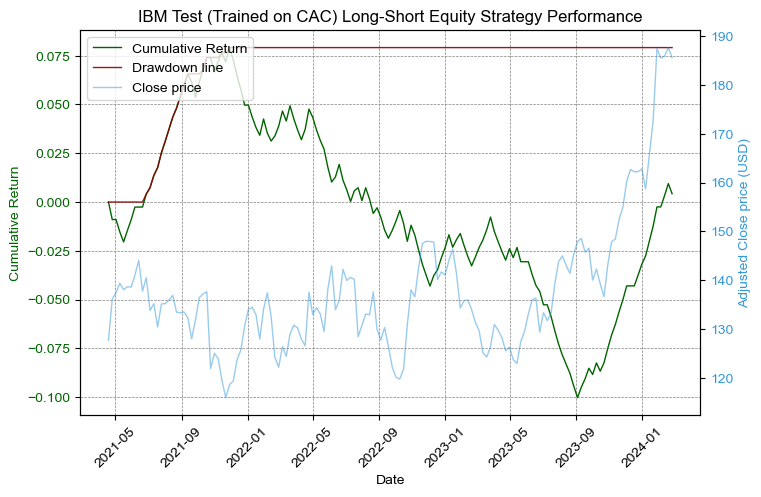

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 3.2 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 19 weeks
────────────────────────────────────────
Cumulative return over the period: -5.5 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 50 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 49.0 %
────────────────────────────────────────
Cumulative return over the period: 49.2 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 28 weeks
────────────────────────────────────────


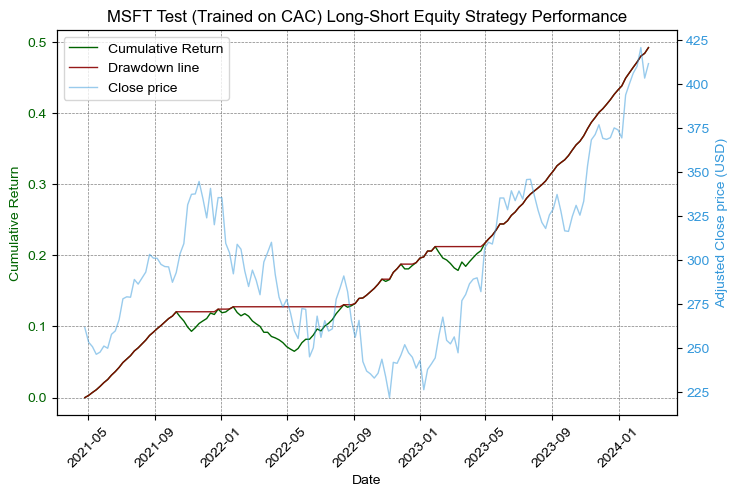

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 8.1 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 12 weeks
────────────────────────────────────────
Cumulative return over the period: 11.6 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 19.6 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 66 weeks
────────────────────────────────────────


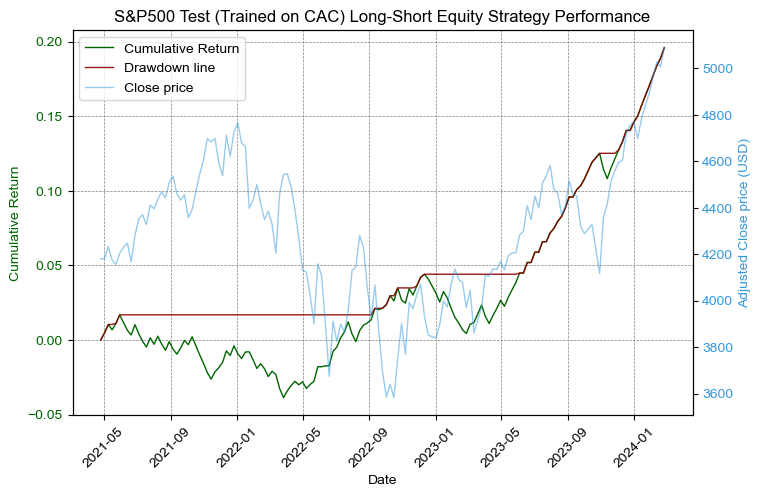

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -2.8 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 46 weeks
────────────────────────────────────────
Cumulative return over the period: 4.8 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 18 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 32.1 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 25 weeks
────────────────────────────────────────


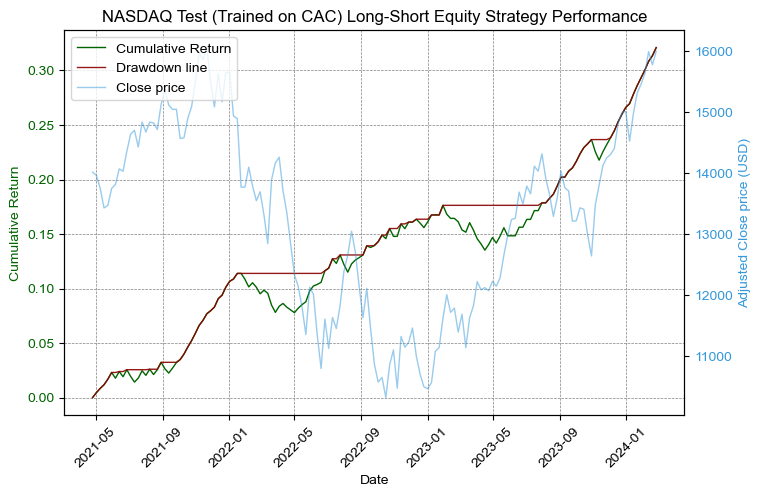

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 8.3 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 12 weeks
────────────────────────────────────────
Cumulative return over the period: 5.1 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [43]:
for df_name, df in test_dfs.items():
    if df_name != 'CAC Test':  # Skip the current test dataset for cross-testing

        actual_labels_test = df['Next_week_market_behavior']
        
        X_test = df[feature_columns].values
        
        X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
        X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

        predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

        print(f'Cross-testing on {df_name}')
        # Accuracy
        accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
        print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
        print('─' * 40)

        # Returns
        df['Prediction'] = predicted_labels_test

        df=utilities.calculate_returns(df, 'Prediction')
        
        max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
        
        print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
        print('─' * 40) 

        utilities.plot_return(df, df_name+' (Trained on CAC)', save_figure=True)

        utilities.calculate_yearly_returns(df)

        print('─' * 100)

***
## S&P500 dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.15677
epoch   10: Loss=1.03965
epoch   20: Loss=1.02804
epoch   30: Loss=1.02612
epoch   40: Loss=1.02400
epoch   50: Loss=1.02274
epoch   60: Loss=1.02188
epoch   70: Loss=1.02121
epoch   80: Loss=1.02067
epoch   90: Loss=1.02020
epoch  100: Loss=1.01969
epoch  110: Loss=1.01916
epoch  120: Loss=1.01864
epoch  130: Loss=1.01809
epoch  140: Loss=1.01750
epoch  150: Loss=1.01690
epoch  160: Loss=1.01630
epoch  170: Loss=1.01562
epoch  180: Loss=1.01503
epoch  190: Loss=1.01452
epoch  200: Loss=1.01425
epoch  210: Loss=1.01382
epoch  220: Loss=1.01328
epoch  230: Loss=1.01491
epoch  240: Loss=1.01240
epoch  250: Loss=1.01284
epoch  260: Loss=1.01149
epoch  270: Loss=1.01202
epoch  280: Loss=1.01160
epoch  290: Loss=1.01151
epoch  300: Loss=1.00990
epoch  310: Loss=1.01011
epoch  320: Loss=1.01019
epoch  330: Loss=1.00823
epoch  340: Loss=1.00814
epoch  350: Loss=1.00842
epoch  360: Loss=1.00526
epoch  370: Loss=1.

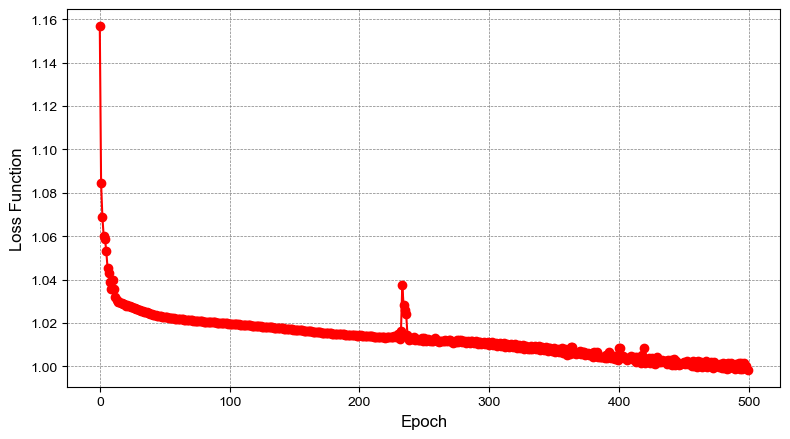

In [44]:
df=sp500
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 49.0 %
────────────────────────────────────────


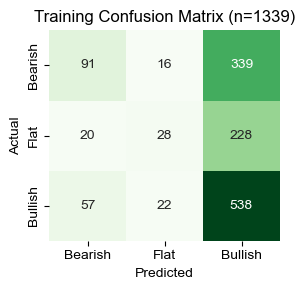

In [45]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 42.0 %
────────────────────────────────────────


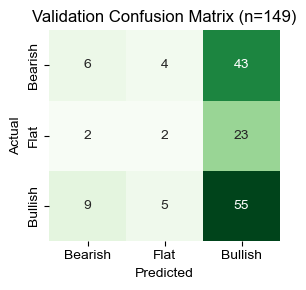

In [46]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 11329.6 %
Baseline Return (Buy and Hold over the period): 808.6 %
Maximum Drawdown Duration 130 weeks


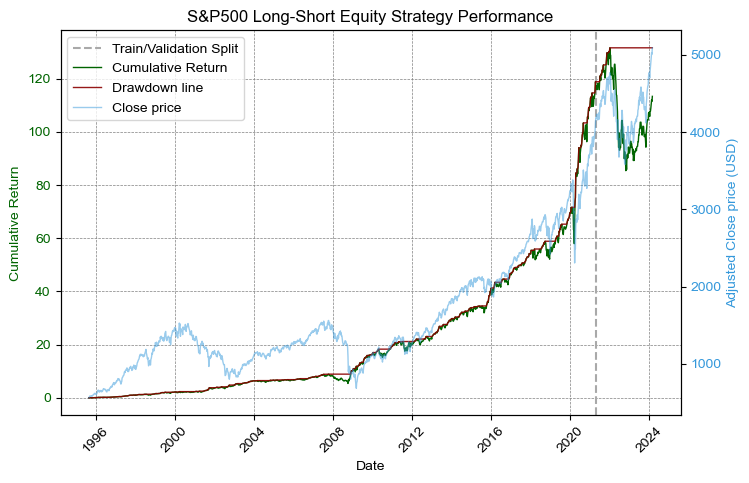

In [47]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'S&P500', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 61.7 %
Baseline Return (Buy and Hold over the period): 21.7 %
Validation Set Maximum Drawdown: 8 weeks


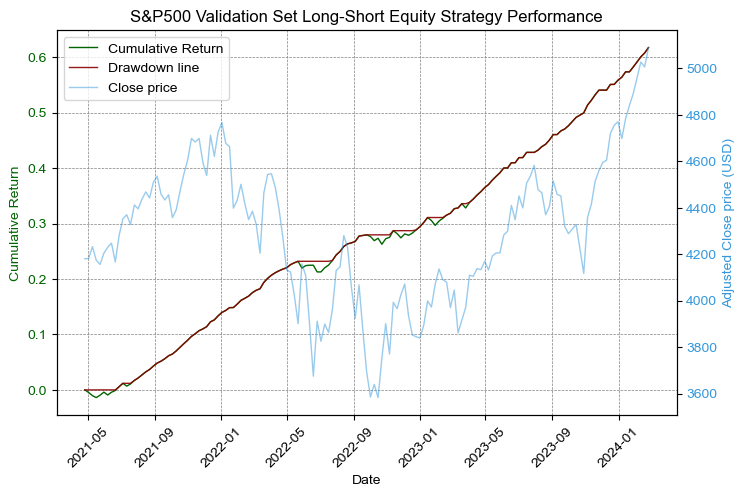

In [48]:
sp500_test_df['Prediction']=predicted_labels_test
sp500_test_df = utilities.calculate_returns(sp500_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(sp500_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(sp500_test_df, 'S&P500 Validation Set', save_figure=True)

In [49]:
utilities.calculate_yearly_returns(sp500_test_df)

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 21.5 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: 11.0 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────


Cross-testing on AMZN Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 39.9 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 17 weeks
────────────────────────────────────────


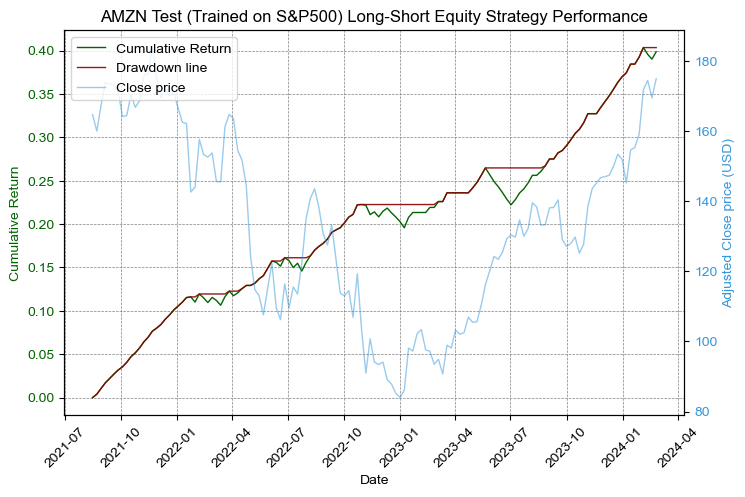

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.3 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: 7.4 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 17 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 36.0 %
────────────────────────────────────────
Cumulative return over the period: -8.6 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 127 weeks
────────────────────────────────────────


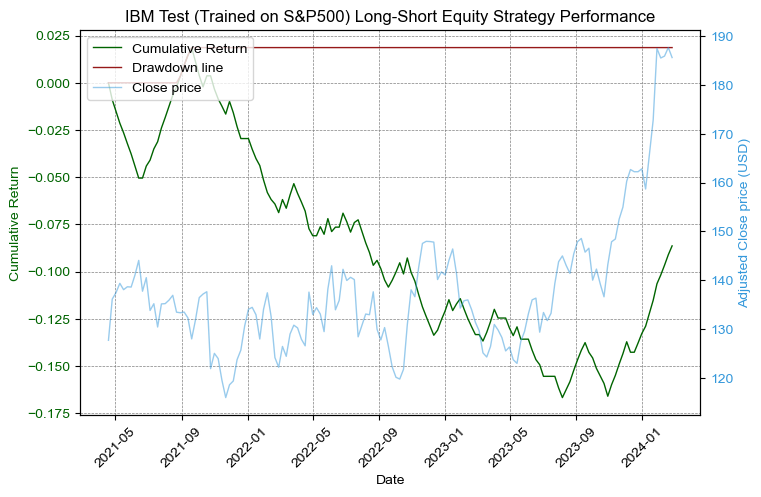

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -6.3 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 29 weeks
────────────────────────────────────────
Cumulative return over the period: -6.1 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 37.9 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 31 weeks
────────────────────────────────────────


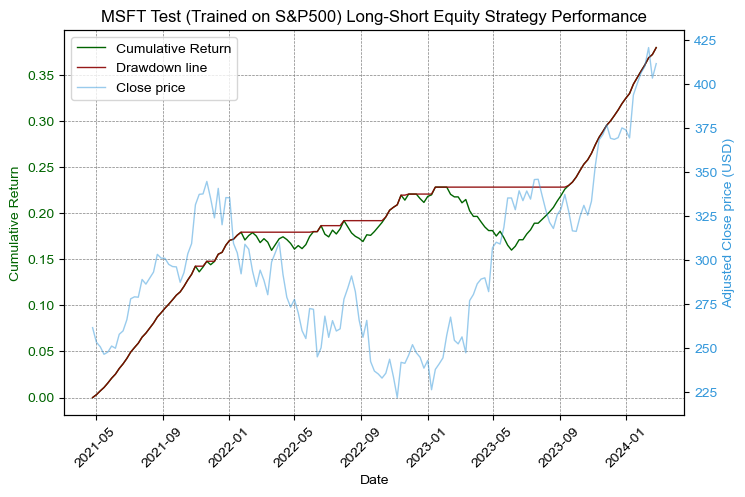

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 17.1 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 12 weeks
────────────────────────────────────────
Cumulative return over the period: 1.5 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 10 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 31.6 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 65 weeks
────────────────────────────────────────


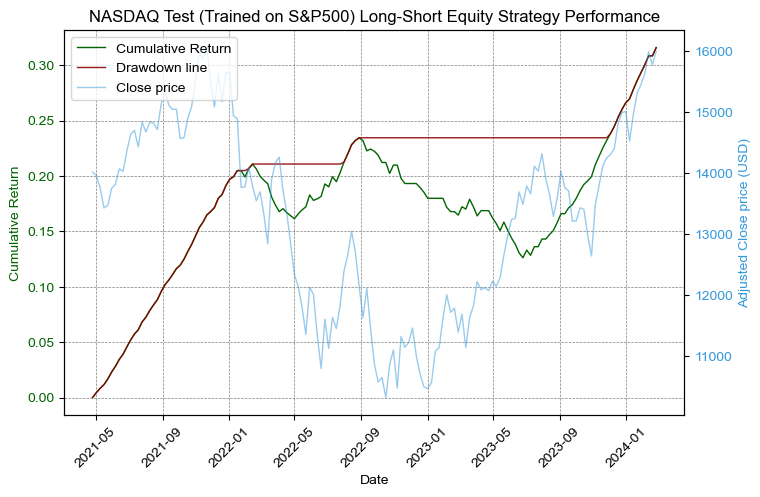

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.7 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
Cumulative return over the period: 0.4 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 33 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 42.0 %
────────────────────────────────────────
Cumulative return over the period: 41.1 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 33 weeks
────────────────────────────────────────


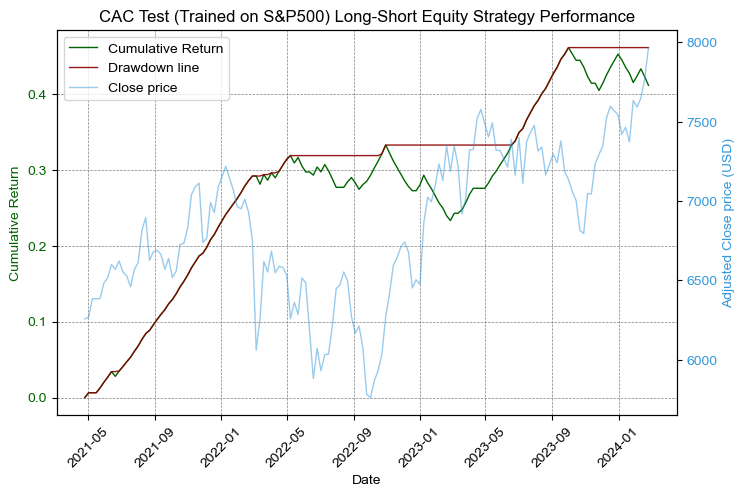

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 29.8 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 1 weeks
────────────────────────────────────────
Cumulative return over the period: -2.3 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 24 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [50]:
for df_name, df in test_dfs.items():
    if df_name != 'S&P500 Test':  # Skip the current test dataset for cross-testing

        actual_labels_test = df['Next_week_market_behavior']
        
        X_test = df[feature_columns].values
        
        X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
        X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

        predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

        print(f'Cross-testing on {df_name}')
        # Accuracy
        accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
        print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
        print('─' * 40)

        # Returns
        df['Prediction'] = predicted_labels_test

        df=utilities.calculate_returns(df, 'Prediction')
        
        max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
        
        print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
        print('─' * 40) 

        utilities.plot_return(df, df_name+' (Trained on S&P500)', save_figure=True)

        utilities.calculate_yearly_returns(df)

        print('─' * 100)

***
## NASDAQ dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.14571
epoch   10: Loss=1.05320
epoch   20: Loss=1.05488
epoch   30: Loss=1.02949
epoch   40: Loss=1.01813
epoch   50: Loss=1.01246
epoch   60: Loss=1.01032
epoch   70: Loss=1.00673
epoch   80: Loss=1.00481
epoch   90: Loss=1.00336
epoch  100: Loss=1.00583
epoch  110: Loss=1.00135
epoch  120: Loss=1.00015
epoch  130: Loss=0.99918
epoch  140: Loss=0.99819
epoch  150: Loss=0.99727
epoch  160: Loss=0.99880
epoch  170: Loss=0.99788
epoch  180: Loss=0.99579
epoch  190: Loss=0.99563
epoch  200: Loss=0.99487
epoch  210: Loss=0.99393
epoch  220: Loss=0.99313
epoch  230: Loss=0.99263
epoch  240: Loss=0.99221
epoch  250: Loss=0.99146
epoch  260: Loss=0.99054
epoch  270: Loss=0.99044
epoch  280: Loss=0.98946
epoch  290: Loss=0.98942
epoch  300: Loss=0.98880
epoch  310: Loss=0.98777
epoch  320: Loss=0.98717
epoch  330: Loss=0.98654
epoch  340: Loss=0.98582
epoch  350: Loss=0.98611
epoch  360: Loss=0.98597
epoch  370: Loss=0.

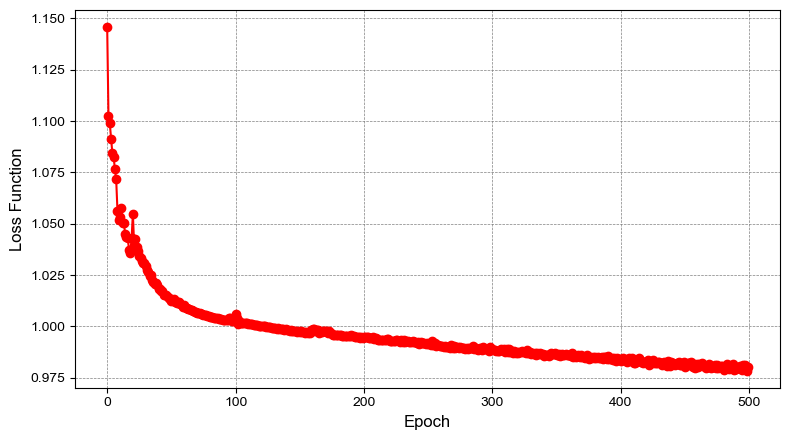

In [51]:
df=nasdaq
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 51.0 %
────────────────────────────────────────


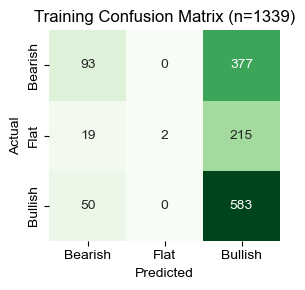

In [52]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 48.0 %
────────────────────────────────────────


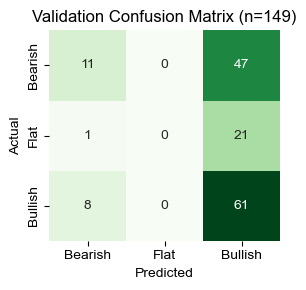

In [53]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 32824.2 %
Baseline Return (Buy and Hold over the period): 1468.4 %
Maximum Drawdown Duration 130 weeks


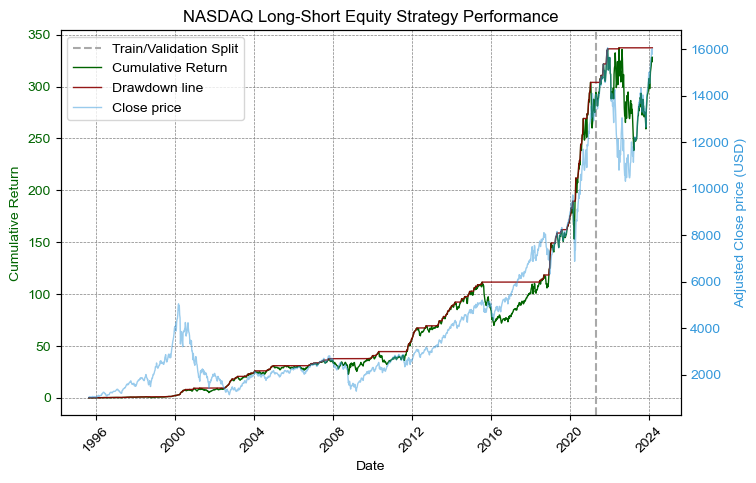

In [54]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'NASDAQ', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 69.5 %
Baseline Return (Buy and Hold over the period): 14.1 %
Validation Set Maximum Drawdown: 24 weeks


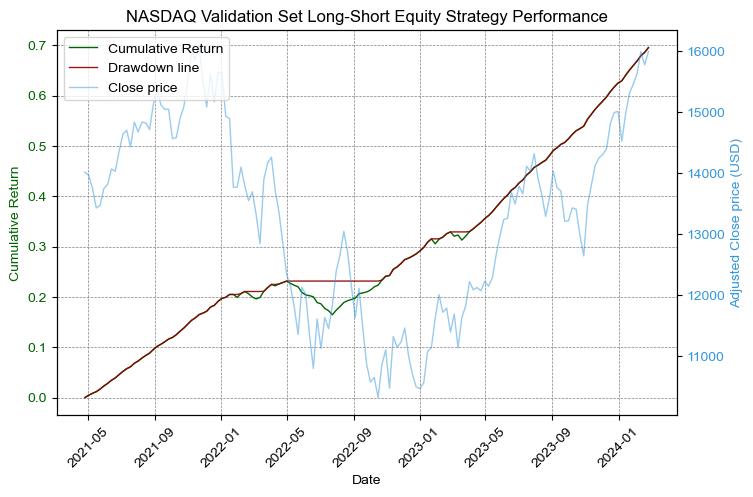

In [55]:
nasdaq_test_df['Prediction']=predicted_labels_test
nasdaq_test_df = utilities.calculate_returns(nasdaq_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(nasdaq_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(nasdaq_test_df, 'NASDAQ Validation Set', save_figure=True)

In [56]:
utilities.calculate_yearly_returns(nasdaq_test_df)

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 22.6 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: 9.2 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 24 weeks
────────────────────────────────────────


Cross-testing on AMZN Test
Cross-Test Accuracy: 37.0 %
────────────────────────────────────────
Cumulative return over the period: 29.4 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 27 weeks
────────────────────────────────────────


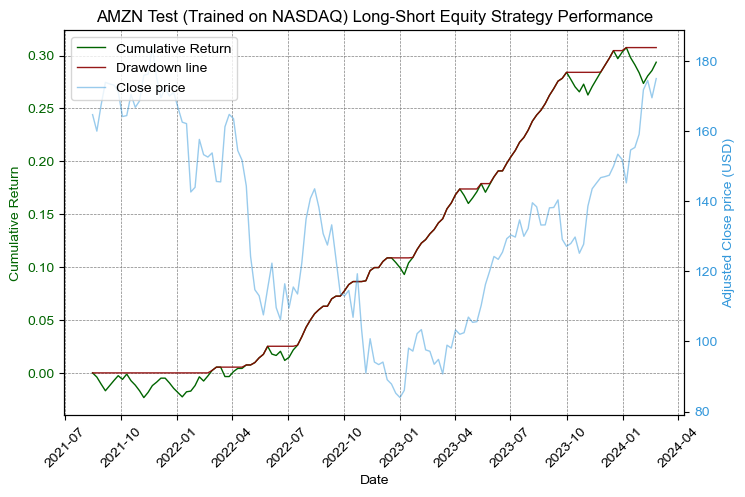

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 5.0 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 27 weeks
────────────────────────────────────────
Cumulative return over the period: 17.2 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 39.0 %
────────────────────────────────────────
Cumulative return over the period: 28.1 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 19 weeks
────────────────────────────────────────


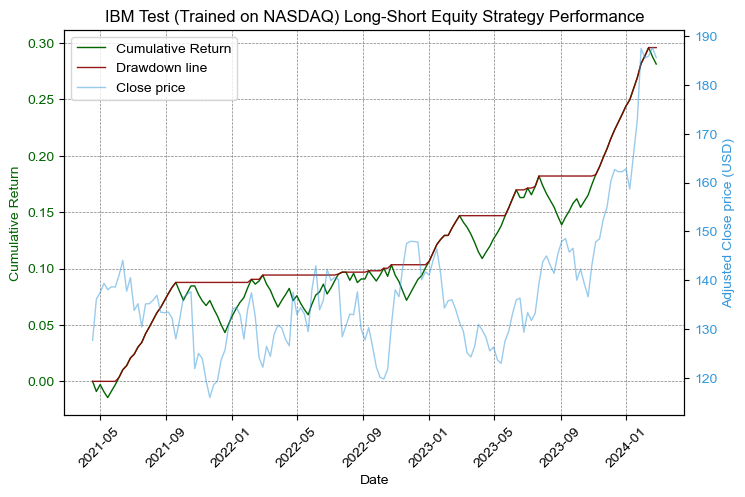

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 7.7 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 19 weeks
────────────────────────────────────────
Cumulative return over the period: 2.4 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 42.0 %
────────────────────────────────────────
Cumulative return over the period: 18.2 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 102 weeks
────────────────────────────────────────


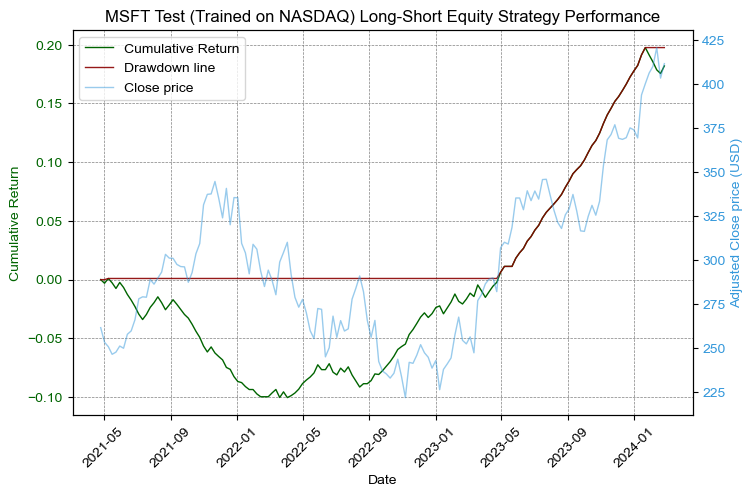

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -9.7 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 49 weeks
────────────────────────────────────────
Cumulative return over the period: 9.7 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 15 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 42.0 %
────────────────────────────────────────
Cumulative return over the period: 14.3 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 116 weeks
────────────────────────────────────────


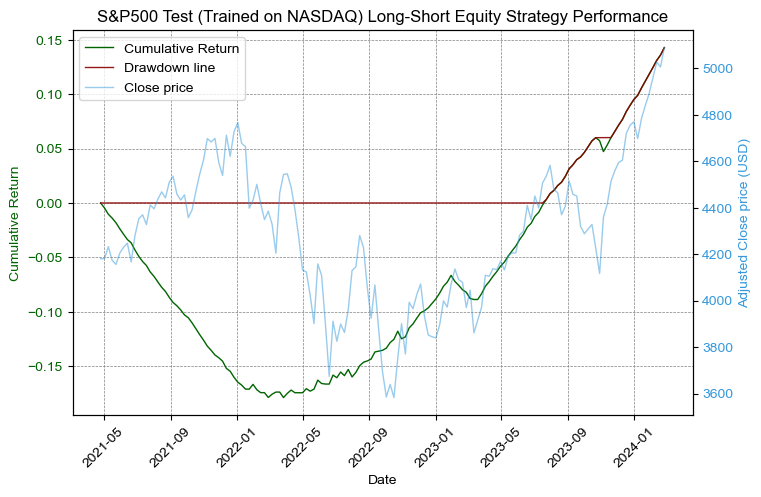

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -17.4 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
Cumulative return over the period: 13.0 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 14.6 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 119 weeks
────────────────────────────────────────


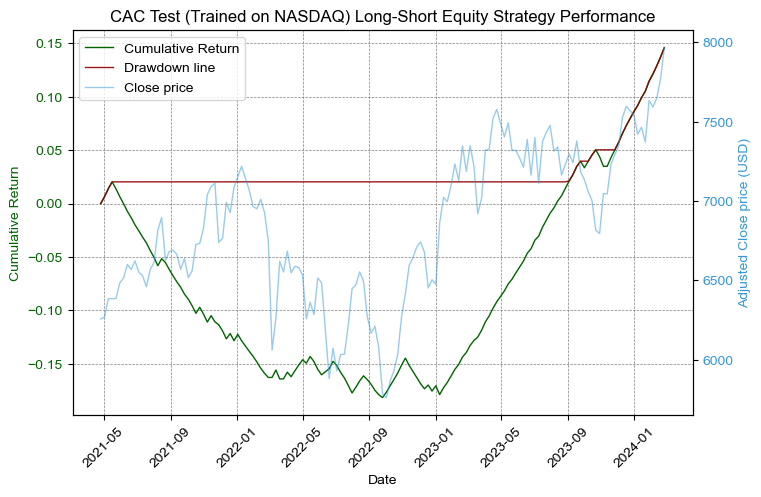

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -15.7 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 48 weeks
────────────────────────────────────────
Cumulative return over the period: 6.3 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 40 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [57]:
for df_name, df in test_dfs.items():
    if df_name != 'NASDAQ Test':  # Skip the current test dataset for cross-testing

        actual_labels_test = df['Next_week_market_behavior']
        
        X_test = df[feature_columns].values
        
        X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
        X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

        predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

        print(f'Cross-testing on {df_name}')
        # Accuracy
        accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
        print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
        print('─' * 40)

        # Returns
        df['Prediction'] = predicted_labels_test

        df=utilities.calculate_returns(df, 'Prediction')
        
        max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
        
        print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
        print('─' * 40) 

        utilities.plot_return(df, df_name+' (Trained on NASDAQ)', save_figure=True)

        utilities.calculate_yearly_returns(df)

        print('─' * 100)